In [1]:
import sys  
sys.path.insert(0, '/Users/navinlr/Desktop/Thesis/code_base/conversation_quality')

In [2]:
# from dataset_creation import dataset_creator as data_generator
from feature_extract import turntake_extractor as feat_extractor
from modeling import dataset_provider as data_gen
from dataset_creation import dataset_creator as data_generator

import feature_namer_script as feat_namer
import constants

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sns.set(rc={'figure.figsize':(11.7,8.27)})

Total Groups = 115


In [3]:
# TEST Variables
agreeability_thresh=.2
missing_data_thresh=50.0 #(in percent)

annotators=["Divya", "Nakul"]#, "Swathi"]
zero_mean = False
from_store= True
filter_missing_data=True
transform_features=True
add_interactions=False
only_involved_pairs=True
manifest="group"

dataset=[constants.features_dataset_path_v7, constants.features_dataset_path_v13] #, constants.features_dataset_path_v13
dataset_feat=[feat_namer.get_feature_names_for_dataset_7, feat_namer.get_feature_names_for_dataset_13]

In [4]:
# Get Synchrony/Convergence features for IDs (group/ indiv) & respec., Annotations Reader
X=[]
feature_names=[]
for i, curr_dataset in enumerate(dataset):
    curr_X, reliable_convqs, reliable_ids = data_gen.get_dataset_for_experiment(dataset=curr_dataset,
                                                                        manifest=manifest,
                                                                        missing_data_thresh=missing_data_thresh,
                                                                        agreeability_thresh=agreeability_thresh,
                                                                        annotators=annotators,
                                                                        only_involved_pairs=only_involved_pairs,
                                                                        zero_mean=zero_mean)
    feature_names.extend(dataset_feat[i]())
    if len(X) == 0:
        X=curr_X
    else:
        X=np.concatenate((X, curr_X), axis=1)        

print("Synchrony Feature-Set Size = " + str(X.shape))
print("Total Samples in Analysis - " + str(len(reliable_ids)))

Generating Dataset for modeling - group ConvQ, ...........
Number of Groups (After removing missing data) - 85
ZERO-MEAN Technique ? - False
ZERO-MEAN Technique ? - False


22it [00:00, 218.91it/s]

Number of Final Data-points (After removing unreliable annotation data) - 58
Dataset for modeling ConvQ Generated !!!!!!


58it [00:00, 210.06it/s]


Total #Features = 756
Generating Dataset for modeling - group ConvQ, ...........
Number of Groups (After removing missing data) - 85
ZERO-MEAN Technique ? - False
ZERO-MEAN Technique ? - False


58it [00:00, 886.11it/s]

Number of Final Data-points (After removing unreliable annotation data) - 58
Dataset for modeling ConvQ Generated !!!!!!
Total #Features = 126
Synchrony Feature-Set Size = (58, 882)
Total Samples in Analysis - 58


In [5]:
# Transform Features
if transform_features:
    print("Transforming Dataset...")
    from sklearn.preprocessing import StandardScaler
    X = StandardScaler().fit_transform(X)
#     reliable_convqs = StandardScaler().fit_transform(np.array(reliable_convqs).reshape(-1, 1))

Transforming Dataset...


In [6]:
# Get groups sizes (for indiv and group)
group_sizes = data_generator.get_group_sizes_for_ids(reliable_ids, manifest)

In [7]:
#Dataset Prep
coord_X = pd.DataFrame(data=X, index=reliable_ids, columns=feature_names) 
coord_X["convq"] = reliable_convqs
coord_X["group_sizes"] = group_sizes
# print(coord_X[2:])

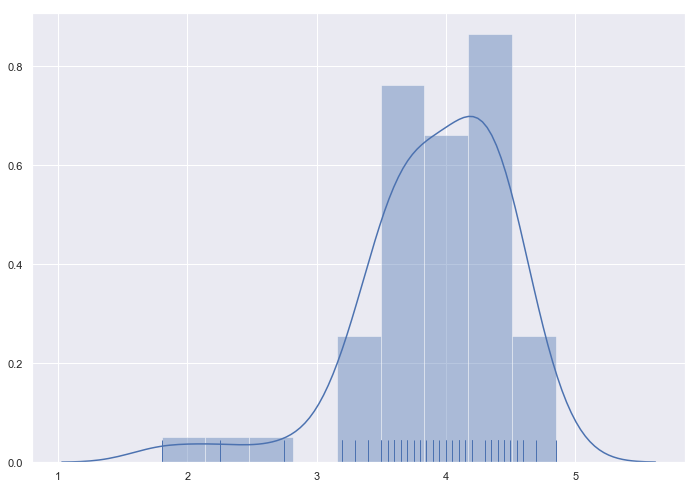

W-Stat = 0.9050574898719788
P-Value-Stat = 0.00025824207114055753


In [8]:
# Plots - Qualitative Analysis
sns.distplot(reliable_convqs, kde=True, rug=True)
plt.show()

from scipy import stats
# x = stats.norm.rvs(loc=5, scale=3, size=100)
W, p_val = stats.shapiro(reliable_convqs)


print("W-Stat = " + str(W))
print("P-Value-Stat = " + str(p_val))

In [9]:
# Statistical Tests:(Main Question)
# Do Turn-Taking features have a significant effect on the Perceived Individual's Experience of Conversation Quality?
# TT Features can be categorised into three categories -> Equality, Fluency and Synchronisation
#
# (Sub Question)
# Does Conversation Equality have a significant effect on the Perceived Individual's Experience of Conversation Quality?
#  1. Use Features "#turns", "%talk", "mean_turn". 
#
# (Sub Question)
# Does Conversation Fluency have a significant effect on the Perceived Individual's Experience of Conversation Quality?
# 1. Use Features "%silence", "mean_silence", "#bc". 
# 
# (Sub Question)
# Does Conversation Synchronisation have a significant effect on the Perceived Individual's Experience of Conversation Quality?
# 1. Use Features "%overlap", "#suc_interupt", "#un_interupt". 
# 
# For all above questions, after (1), perform below steps,
#  2. Fit a Quantile Least Square Regression model on the features vs the convq score.
#  3. Analyse p-value significance @ p<0.05
#  4. Check the co-efficients for informations.

In [10]:
final_test_features = list(feature_names)
final_test_features.append("group_sizes")
final_test_features.append("const")

In [49]:
# Handle MultiCollinearity/Full Rank problem
# Temp.Sol -> Use only Magnitude features
final_mag_sync_features=["const", "group_sizes"]
final_mag_conv_features=["const", "group_sizes"]
final_mag_caus_features=["const", "group_sizes"]
final_mag_mimi_led_features=["const", "group_sizes"]
final_mag_mimi_lag_features=["const", "group_sizes"]


only_mag_features=["const", "group_sizes"]

for curr_feat in final_test_features:
    if "mag-" in curr_feat:
        if "-mode" not in curr_feat and "-median" not in curr_feat:
            only_mag_features.append(curr_feat)
            if "corr-" in curr_feat or "mi-" in curr_feat:
                final_mag_sync_features.append(curr_feat)
            elif "conv-" in curr_feat:
                final_mag_conv_features.append(curr_feat)
            elif "mimicry-" in curr_feat:
                if "_lag_" in curr_feat:
                    final_mag_mimi_lag_features.append(curr_feat)
                else:
                    final_mag_mimi_led_features.append(curr_feat)                    
            elif "granger-" in curr_feat or "coherence-" in curr_feat:
                final_mag_caus_features.append(curr_feat)
        
print("#Sync Features = " + str(len(final_mag_sync_features)))
print("#Conv Features = " + str(len(final_mag_conv_features)))
print("#Caus Features = " + str(len(final_mag_caus_features)))
print("#Lag Mimi Features = " + str(len(final_mag_mimi_lag_features)))
print("#Led Mimi Features = " + str(len(final_mag_mimi_led_features)))


print("#Total Features = " + str(len(only_mag_features)))

#Sync Features = 26
#Conv Features = 18
#Caus Features = 14
#Lag Mimi Features = 18
#Led Mimi Features = 18
#Total Features = 86


In [50]:
# Experiment Below

# Ordinary Regression
import statsmodels.api as sm
import statsmodels.formula.api as smf

model_test=sm.OLS#sm.regression.quantile_regression.QuantReg#sm.OLS
test_X = sm.add_constant(coord_X)

max_iter=100000
q=0.5
vcov="iid"
kernel="cos"

print("significance @ 0.05/3 = 0.02 after Bonferroni correction for 3 tests (eq, fluency, sync)")
print()
print()
print("~~~~~~~~~~~~~~~~~~~~~~~ Synchrony Coordination Test ~~~~~~~~~~~~~~~~~~~~~~~")
model = model_test(reliable_convqs, test_X.loc[:,final_mag_sync_features])
results = model.fit(max_iter=max_iter, q=q, vcov=vcov, kernel=kernel)
print(results.summary())

print()
print()

print("~~~~~~~~~~~~~~~~~~~~~~~ Convergence Coordination Test ~~~~~~~~~~~~~~~~~~~~~~~")
model = model_test(reliable_convqs, test_X.loc[:,final_mag_conv_features])
results = model.fit(max_iter=max_iter, q=q, vcov=vcov, kernel=kernel)
print(results.summary())
print()
print()

print("~~~~~~~~~~~~~~~~~~~~~~~ Led Mimicry Coordination Test ~~~~~~~~~~~~~~~~~~~~~~~")
model = model_test(reliable_convqs, test_X.loc[:,final_mag_mimi_led_features])
results = model.fit(max_iter=max_iter, q=q, vcov=vcov, kernel=kernel)
print(results.summary())
print()
print()

print("~~~~~~~~~~~~~~~~~~~~~~~ Lag Mimicry Coordination Test ~~~~~~~~~~~~~~~~~~~~~~~")
model = model_test(reliable_convqs, test_X.loc[:,final_mag_mimi_lag_features])
results = model.fit(max_iter=max_iter, q=q, vcov=vcov, kernel=kernel)
print(results.summary())
print()
print()

print("~~~~~~~~~~~~~~~~~~~~~~~ Causality Coordination Test ~~~~~~~~~~~~~~~~~~~~~~~")
model = model_test(reliable_convqs, test_X.loc[:,final_mag_caus_features])
results = model.fit(max_iter=max_iter, q=q, vcov=vcov, kernel=kernel)
print(results.summary())
print()
print()

significance @ 0.05/3 = 0.02 after Bonferroni correction for 3 tests (eq, fluency, sync)


~~~~~~~~~~~~~~~~~~~~~~~ Synchrony Coordination Test ~~~~~~~~~~~~~~~~~~~~~~~
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     1.724
Date:                Fri, 12 Jun 2020   Prob (F-statistic):             0.0735
Time:                        10:20:20   Log-Likelihood:                -28.630
No. Observations:                  58   AIC:                             101.3
Df Residuals:                      36   BIC:                             146.6
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                              coef    std e